In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

try Monotone interpolants https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html

In [4]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

In [5]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [86]:
BAAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/R CRB_20231107_054548.csv')
BAAVSO

,Object,Julian Date,UT,Magnitude Qualifier,Magnitude,Magnitude Error,Observer Name,Method,Equipment,Filter,Chart / Sequence,Visual Estimates,CCD Measurement Data: Measurement Type;Star Type;Star Id;Measured Mag;Measured Error;Reference Mag;Reference Error,Observation_Id
0,R CRB,2.460252e+06,3 Nov 2023 17:50:00,Equal,6.5,NaN,G Poyner,Visual,10x50B,No Filter,041.04,V=E,NaN,4806842
1,R CRB,2.460247e+06,29 Oct 2023 18:15:00,Equal,6.7,NaN,S W Albrighton,Visual,20x80B,No Filter,041.04,E-2,NaN,4805529
2,R CRB,2.460247e+06,29 Oct 2023 18:10:00,Equal,6.4,NaN,G Poyner,Visual,10x50B,No Filter,041.04,E+1,NaN,4805589
3,R CRB,2.460245e+06,27 Oct 2023 18:41:00,Equal,6.7,NaN,J Toone,Visual,B7X50,No Filter,41.04,E(1)V(4)G,NaN,4805974
4,R CRB,2.460245e+06,27 Oct 2023 18:09:00,Equal,6.4,NaN,J D Shanklin,Visual,B20x80,No Filter,041.04,E+1,NaN,4805684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57389,R CRB,2.396574e+06,1 Jul 1849 00:00:00,Equal,6.4,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+8,NaN,2593012
57390,R CRB,2.396536e+06,23 May 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593011
57391,R CRB,2.396500e+06,17 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593010
57392,R CRB,2.396484e+06,1 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593009


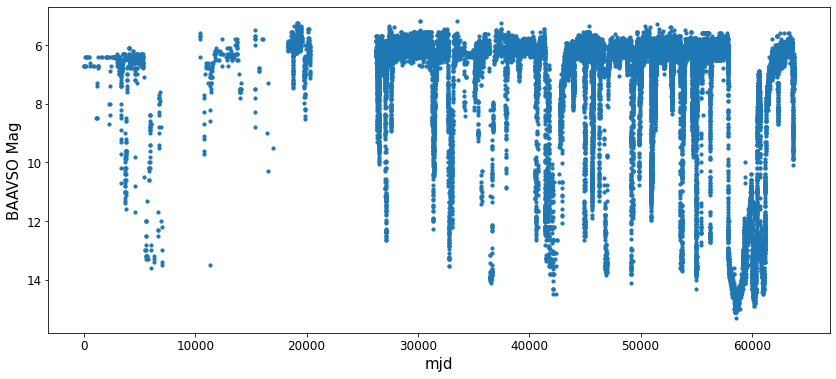

In [91]:
plt.figure(figsize=(14,6))

plt.scatter(BAAVSO['Julian Date']-np.min(BAAVSO['Julian Date']),BAAVSO['Magnitude'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd')
plt.ylabel('BAAVSO Mag')
plt.show()

In [95]:
# pretend this dataframe is something else
oband = BAAVSO
oband.rename(columns={"Julian Date": "mjd", "Magnitude": "m"},inplace=True)
oband

,Object,mjd,UT,Magnitude Qualifier,m,Magnitude Error,Observer Name,Method,Equipment,Filter,Chart / Sequence,Visual Estimates,CCD Measurement Data: Measurement Type;Star Type;Star Id;Measured Mag;Measured Error;Reference Mag;Reference Error,Observation_Id
0,R CRB,2.460252e+06,3 Nov 2023 17:50:00,Equal,6.5,NaN,G Poyner,Visual,10x50B,No Filter,041.04,V=E,NaN,4806842
1,R CRB,2.460247e+06,29 Oct 2023 18:15:00,Equal,6.7,NaN,S W Albrighton,Visual,20x80B,No Filter,041.04,E-2,NaN,4805529
2,R CRB,2.460247e+06,29 Oct 2023 18:10:00,Equal,6.4,NaN,G Poyner,Visual,10x50B,No Filter,041.04,E+1,NaN,4805589
3,R CRB,2.460245e+06,27 Oct 2023 18:41:00,Equal,6.7,NaN,J Toone,Visual,B7X50,No Filter,41.04,E(1)V(4)G,NaN,4805974
4,R CRB,2.460245e+06,27 Oct 2023 18:09:00,Equal,6.4,NaN,J D Shanklin,Visual,B20x80,No Filter,041.04,E+1,NaN,4805684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57389,R CRB,2.396574e+06,1 Jul 1849 00:00:00,Equal,6.4,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+8,NaN,2593012
57390,R CRB,2.396536e+06,23 May 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593011
57391,R CRB,2.396500e+06,17 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593010
57392,R CRB,2.396484e+06,1 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593009


In [267]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,Object,mjd,UT,Magnitude Qualifier,m,Magnitude Error,Observer Name,Method,Equipment,Filter,Chart / Sequence,Visual Estimates,CCD Measurement Data: Measurement Type;Star Type;Star Id;Measured Mag;Measured Error;Reference Mag;Reference Error,Observation_Id
0,R CRB,2.396468e+06,16 Mar 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593008
1,R CRB,2.396484e+06,1 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593009
2,R CRB,2.396500e+06,17 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593010
3,R CRB,2.396536e+06,23 May 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593011
4,R CRB,2.396574e+06,1 Jul 1849 00:00:00,Equal,6.4,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+8,NaN,2593012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52509,R CRB,2.460245e+06,27 Oct 2023 18:09:00,Equal,6.4,NaN,J D Shanklin,Visual,B20x80,No Filter,041.04,E+1,NaN,4805684
52510,R CRB,2.460245e+06,27 Oct 2023 18:41:00,Equal,6.7,NaN,J Toone,Visual,B7X50,No Filter,41.04,E(1)V(4)G,NaN,4805974
52511,R CRB,2.460247e+06,29 Oct 2023 18:10:00,Equal,6.4,NaN,G Poyner,Visual,10x50B,No Filter,041.04,E+1,NaN,4805589
52512,R CRB,2.460247e+06,29 Oct 2023 18:15:00,Equal,6.7,NaN,S W Albrighton,Visual,20x80B,No Filter,041.04,E-2,NaN,4805529


In [6]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.321458,13.924,0.016,9785.0,153.0,o,0,3.59,266.38087,-23.54012,6195.84,7416.94,3.75,3.49,-82.9,-0.560,18.54,19.67,02a57228o0100o
1,57228.346244,13.937,0.016,9667.0,159.0,o,0,5.29,266.38087,-23.54012,4558.21,2938.13,3.75,3.61,-66.5,-0.557,18.59,19.72,02a57228o0126o
2,57228.372911,13.923,0.017,9791.0,163.0,o,0,4.91,266.38087,-23.54012,3135.45,4388.41,3.81,3.56,-80.0,-0.552,18.59,19.75,02a57228o0155o
3,57228.399363,13.950,0.018,9554.0,168.0,o,0,3.62,266.38087,-23.54012,3133.42,4389.66,3.57,3.36,-72.6,-0.560,18.65,19.76,02a57228o0184o
4,57241.301290,15.582,0.026,2124.0,56.0,c,0,6.14,266.38087,-23.54012,4315.84,3159.06,4.14,4.06,-46.8,-0.466,19.08,20.95,02a57241o0078c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,60244.046204,13.938,0.017,9654.0,166.0,o,0,2.34,266.38087,-23.54012,9025.34,3776.44,3.22,2.70,-19.4,-0.466,17.79,18.51,04a60244o0130o
1010,60247.000123,13.909,0.013,9921.0,130.0,o,0,6.07,266.38087,-23.54012,1556.51,1753.60,2.42,2.15,44.3,-0.505,18.18,18.87,04a60247o0015o
1011,60247.003294,13.913,0.008,9879.0,83.0,o,0,16.74,266.38087,-23.54012,1572.91,1792.68,2.39,2.03,46.7,-0.474,18.27,19.24,04a60247o0022o
1012,60247.008746,13.899,0.012,10006.0,120.0,o,0,7.24,266.38087,-23.54012,1509.54,1716.22,2.59,2.12,44.6,-0.502,18.37,19.45,04a60247o0034o


In [7]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.321458,13.924,0.016,9785.0,153.0,o,0,3.59,266.38087,-23.54012,6195.84,7416.94,3.75,3.49,-82.9,-0.560,18.54,19.67,02a57228o0100o
1,57228.346244,13.937,0.016,9667.0,159.0,o,0,5.29,266.38087,-23.54012,4558.21,2938.13,3.75,3.61,-66.5,-0.557,18.59,19.72,02a57228o0126o
2,57228.372911,13.923,0.017,9791.0,163.0,o,0,4.91,266.38087,-23.54012,3135.45,4388.41,3.81,3.56,-80.0,-0.552,18.59,19.75,02a57228o0155o
3,57228.399363,13.950,0.018,9554.0,168.0,o,0,3.62,266.38087,-23.54012,3133.42,4389.66,3.57,3.36,-72.6,-0.560,18.65,19.76,02a57228o0184o
19,57288.220585,13.402,0.011,15821.0,175.0,o,0,4.40,266.38087,-23.54012,4339.76,3175.93,3.80,3.55,-75.2,-0.591,18.09,18.82,02a57288o0018o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,60244.046204,13.938,0.017,9654.0,166.0,o,0,2.34,266.38087,-23.54012,9025.34,3776.44,3.22,2.70,-19.4,-0.466,17.79,18.51,04a60244o0130o
1010,60247.000123,13.909,0.013,9921.0,130.0,o,0,6.07,266.38087,-23.54012,1556.51,1753.60,2.42,2.15,44.3,-0.505,18.18,18.87,04a60247o0015o
1011,60247.003294,13.913,0.008,9879.0,83.0,o,0,16.74,266.38087,-23.54012,1572.91,1792.68,2.39,2.03,46.7,-0.474,18.27,19.24,04a60247o0022o
1012,60247.008746,13.899,0.012,10006.0,120.0,o,0,7.24,266.38087,-23.54012,1509.54,1716.22,2.59,2.12,44.6,-0.502,18.37,19.45,04a60247o0034o


In [8]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.321458,13.924,0.016,9785.0,153.0,o,0,3.59,266.38087,-23.54012,6195.84,7416.94,3.75,3.49,-82.9,-0.560,18.54,19.67,02a57228o0100o
1,57228.346244,13.937,0.016,9667.0,159.0,o,0,5.29,266.38087,-23.54012,4558.21,2938.13,3.75,3.61,-66.5,-0.557,18.59,19.72,02a57228o0126o
2,57228.372911,13.923,0.017,9791.0,163.0,o,0,4.91,266.38087,-23.54012,3135.45,4388.41,3.81,3.56,-80.0,-0.552,18.59,19.75,02a57228o0155o
3,57228.399363,13.950,0.018,9554.0,168.0,o,0,3.62,266.38087,-23.54012,3133.42,4389.66,3.57,3.36,-72.6,-0.560,18.65,19.76,02a57228o0184o
4,57288.220585,13.402,0.011,15821.0,175.0,o,0,4.40,266.38087,-23.54012,4339.76,3175.93,3.80,3.55,-75.2,-0.591,18.09,18.82,02a57288o0018o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,60244.046204,13.938,0.017,9654.0,166.0,o,0,2.34,266.38087,-23.54012,9025.34,3776.44,3.22,2.70,-19.4,-0.466,17.79,18.51,04a60244o0130o
766,60247.000123,13.909,0.013,9921.0,130.0,o,0,6.07,266.38087,-23.54012,1556.51,1753.60,2.42,2.15,44.3,-0.505,18.18,18.87,04a60247o0015o
767,60247.003294,13.913,0.008,9879.0,83.0,o,0,16.74,266.38087,-23.54012,1572.91,1792.68,2.39,2.03,46.7,-0.474,18.27,19.24,04a60247o0022o
768,60247.008746,13.899,0.012,10006.0,120.0,o,0,7.24,266.38087,-23.54012,1509.54,1716.22,2.59,2.12,44.6,-0.502,18.37,19.45,04a60247o0034o


In [9]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.321458,13.924,0.016,9785.0,153.0,o,0,3.59,266.38087,-23.54012,6195.84,7416.94,3.75,3.49,-82.9,-0.560,18.54,19.67,02a57228o0100o
1,57228.346244,13.937,0.016,9667.0,159.0,o,0,5.29,266.38087,-23.54012,4558.21,2938.13,3.75,3.61,-66.5,-0.557,18.59,19.72,02a57228o0126o
2,57228.372911,13.923,0.017,9791.0,163.0,o,0,4.91,266.38087,-23.54012,3135.45,4388.41,3.81,3.56,-80.0,-0.552,18.59,19.75,02a57228o0155o
3,57228.399363,13.950,0.018,9554.0,168.0,o,0,3.62,266.38087,-23.54012,3133.42,4389.66,3.57,3.36,-72.6,-0.560,18.65,19.76,02a57228o0184o
4,57288.220585,13.402,0.011,15821.0,175.0,o,0,4.40,266.38087,-23.54012,4339.76,3175.93,3.80,3.55,-75.2,-0.591,18.09,18.82,02a57288o0018o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,60244.046204,13.938,0.017,9654.0,166.0,o,0,2.34,266.38087,-23.54012,9025.34,3776.44,3.22,2.70,-19.4,-0.466,17.79,18.51,04a60244o0130o
766,60247.000123,13.909,0.013,9921.0,130.0,o,0,6.07,266.38087,-23.54012,1556.51,1753.60,2.42,2.15,44.3,-0.505,18.18,18.87,04a60247o0015o
767,60247.003294,13.913,0.008,9879.0,83.0,o,0,16.74,266.38087,-23.54012,1572.91,1792.68,2.39,2.03,46.7,-0.474,18.27,19.24,04a60247o0022o
768,60247.008746,13.899,0.012,10006.0,120.0,o,0,7.24,266.38087,-23.54012,1509.54,1716.22,2.59,2.12,44.6,-0.502,18.37,19.45,04a60247o0034o


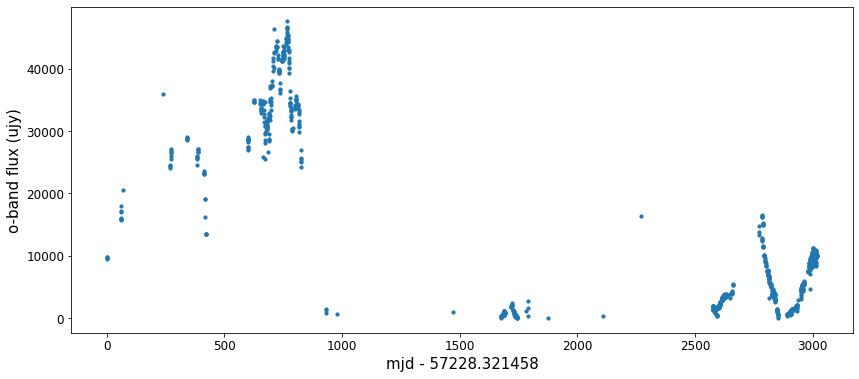

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(-100,1000)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [96]:
########################

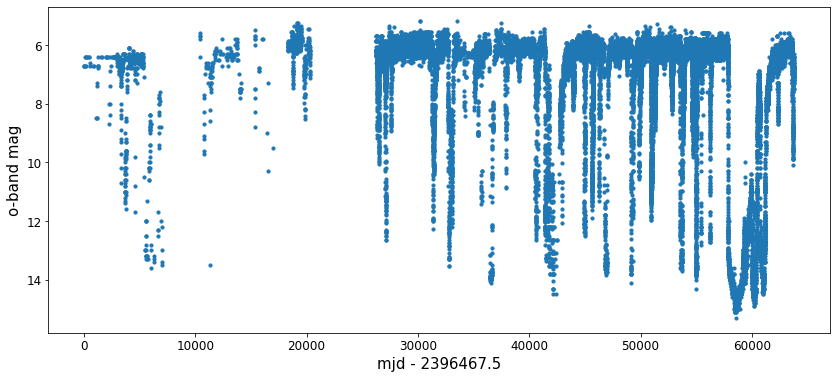

In [268]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band mag')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [98]:
# median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

In [99]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('median filtered o-band magnitude')
# plt.show()

In [269]:
### will fail if duplicate data points
savgol_filtered = non_uniform_savgol(np.asarray(oband['mjd']-oband['mjd'][0]),
                                     np.asarray(oband['m']),
                                   window=7, polynom=1)

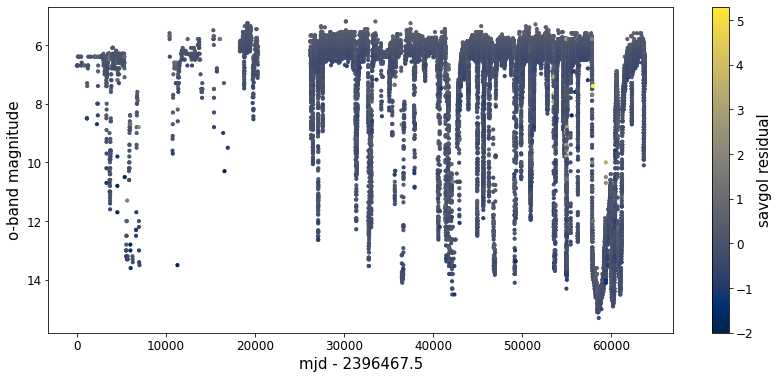

In [270]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=savgol_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.18096343199109358


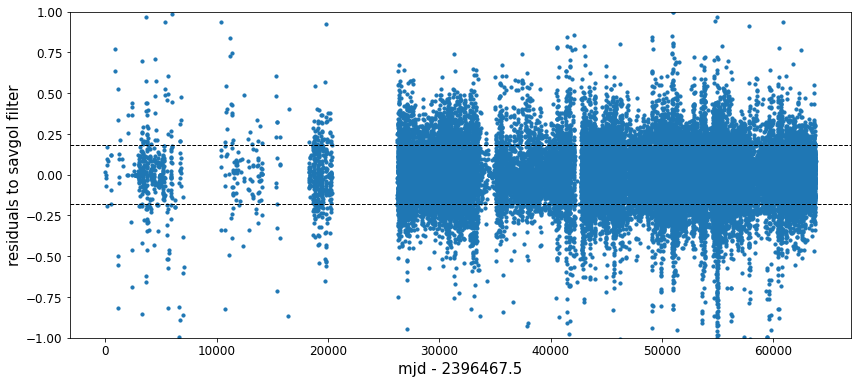

In [271]:
deviation = np.std(savgol_filtered-oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],savgol_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

In [272]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
#             c=median_filtered-oband['m'],cmap='cividis')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band magnitude')
# plt.colorbar(label='median residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [273]:
# deviation = np.std((median_filtered-oband['m']))
# print(deviation)

# plt.figure(figsize=(14,6))
# # plt.axvline(oband['mjd'][1000]-oband['mjd'][0])
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to median filter')
# plt.ylim(-1,1)
# plt.show()

In [274]:
mask = np.where(np.abs(savgol_filtered-oband['m'])<deviation,True,False)
# mask

# mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
# mask

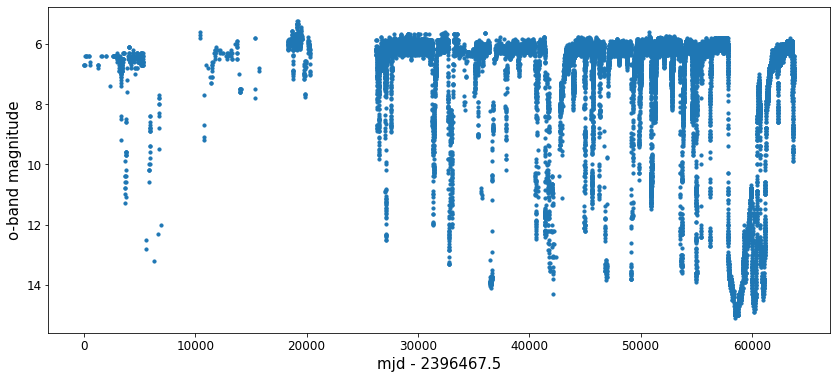

In [275]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [276]:
# median_filtered_oband = oband.iloc[mask]
# median_filtered_oband.reset_index(drop=True,inplace=True)
# median_filtered_oband

savgol_filtered_oband = oband.iloc[mask]
savgol_filtered_oband.reset_index(drop=True,inplace=True)
savgol_filtered_oband

,Object,mjd,UT,Magnitude Qualifier,m,Magnitude Error,Observer Name,Method,Equipment,Filter,Chart / Sequence,Visual Estimates,CCD Measurement Data: Measurement Type;Star Type;Star Id;Measured Mag;Measured Error;Reference Mag;Reference Error,Observation_Id
0,R CRB,2.396468e+06,16 Mar 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593008
1,R CRB,2.396484e+06,1 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593009
2,R CRB,2.396500e+06,17 Apr 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593010
3,R CRB,2.396536e+06,23 May 1849 00:00:00,Equal,6.7,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+5,NaN,2593011
4,R CRB,2.396574e+06,1 Jul 1849 00:00:00,Equal,6.4,NaN,J Baxendell,Visual,G?762,No Filter,Unknown,72+8,NaN,2593012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42513,R CRB,2.460240e+06,22 Oct 2023 19:00:00,Equal,6.5,NaN,S W Albrighton,Visual,20x80B,No Filter,041.04,V=E,NaN,4805493
42514,R CRB,2.460244e+06,26 Oct 2023 18:30:00,Equal,6.4,NaN,S W Albrighton,Visual,20x80B,No Filter,041.04,E+1,NaN,4805510
42515,R CRB,2.460245e+06,27 Oct 2023 18:09:00,Equal,6.4,NaN,J D Shanklin,Visual,B20x80,No Filter,041.04,E+1,NaN,4805684
42516,R CRB,2.460247e+06,29 Oct 2023 18:10:00,Equal,6.4,NaN,G Poyner,Visual,10x50B,No Filter,041.04,E+1,NaN,4805589


In [277]:
iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0]),
                                     np.asarray(savgol_filtered_oband['m']),
                                   window=31, polynom=1)

In [278]:
# iter_savgol_filtered = savgol_filtered_oband['m']

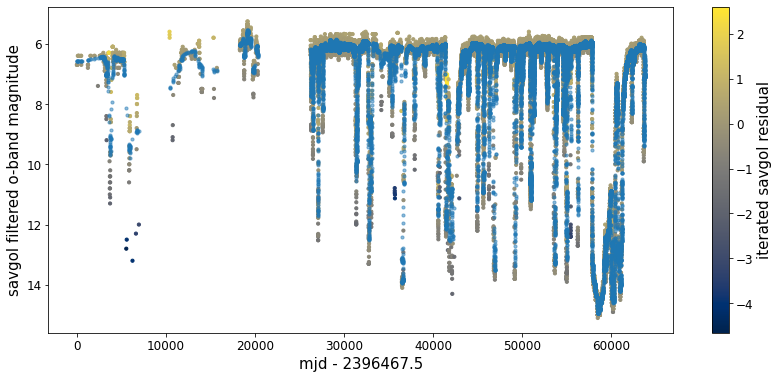

In [279]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.colorbar(label='iterated savgol residual')
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [280]:
# local_std/2

In [281]:
# I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
# and limiting mag is ~20
local_std = np.std((iter_savgol_filtered-savgol_filtered_oband['m']))
saturation_mask = []
halfwidth=5
for i in range(0,len(iter_savgol_filtered)):
    if i > len(iter_savgol_filtered)-halfwidth:
        saturation_mask.append(True)
    elif i < halfwidth:
        saturation_mask.append(True)
    else:
        variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_oband['m'][i-halfwidth:i+halfwidth]))
        if variation_window > 0.1 and np.mean(savgol_filtered_oband['m'][i-halfwidth:i+halfwidth])<12:
    #         print('mask me')
            saturation_mask.append(False)
        else:
            saturation_mask.append(True)
# saturation_mask = np.where(np.abs(iter_savgol_filtered-savgol_filtered_oband['m'])<0.25,True,False)
# saturation_mask

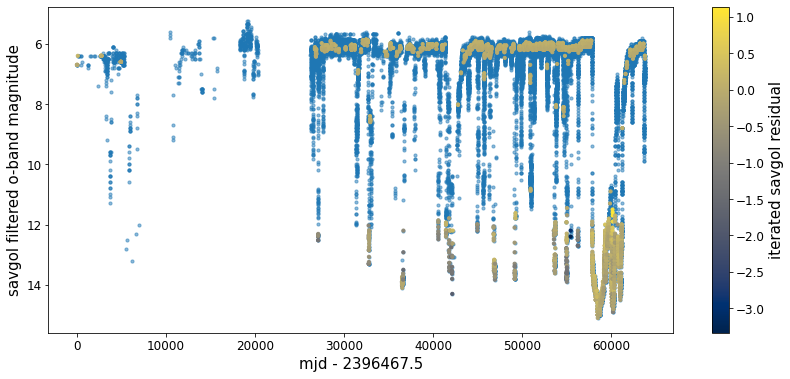

In [282]:
# saturation_replace = np.full(len(saturation_mask),11)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,alpha=0.5)
plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'][saturation_mask],s=10,
            c=iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][np.invert(saturation_mask)]-savgol_filtered_oband['mjd'][0],
#            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
plt.colorbar(label='iterated savgol residual')
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [207]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# # plt.ylim(-1,1)
# plt.show()

In [247]:
# mjd_scale = savgol_filtered_oband['mjd'][0]

# # median_filtered_oband['mjd']-mjd_scale,savgol_filtered
# time = savgol_filtered_oband['mjd']-mjd_scale

# # stddev_arr = []
# # saturation_mask = [False,False,False,False,False]
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# # print(deviation)

# ### find the gaps in the data
# time_diff = np.diff(time)
# time_diff = np.append(time_diff,0)

# gap_mask = []#[False,False]
# for i in range(0,len(time)):
#     if time_diff[i] > 50:
#         gap_mask.append(True)
# #     elif (gap_mask[i-1] == True and gap_mask[i-2] == False):
# #         gap_mask.append(True)
#     else:
#         gap_mask.append(False)
        
# noise_mask = np.full(len(time),False)
# for i in range(0,len(time[gap_mask])):
#     if i == 0:
#         window = time<=time[time[gap_mask].index[i]]
# #         print(window)
#     elif i == len(time[gap_mask])-1:
#         window = time>=time[time[gap_mask].index[i]]
# #         print(window)
#     else:
#         window = np.logical_and(time>=time[time[gap_mask].index[i]],time<=time[time[gap_mask].index[i+1]])
# #     print(np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]))
# #     print(np.mean(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
# #     print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
#     if (np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]) > deviation 
#         and len(savgol_filtered_oband['m'][window]) > 50 and 
#         (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window])) < 2.5
#        and (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m'])) < 3.0):
#         print(len(savgol_filtered_oband['m'][window]))
#         print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window]))
# #         print(i,'mask me')
#         noise_mask[window] = True
# #     print('------')
# noise_mask

In [248]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# # plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],
# #             iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[noise_mask]-savgol_filtered_oband['m'][noise_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][gap_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[gap_mask]-savgol_filtered_oband['m'][gap_mask],s=30)

# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# plt.ylim(-1,1)
# plt.show()

In [249]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
#             c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             savgol_filtered_oband['m'][noise_mask],s=10,color='tab:red')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [250]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
# edge_detect = sp.ndimage.convolve(savgol_filtered_oband['m'], [1.0, 0.0, -1.0])

In [251]:
# mjd_scale = savgol_filtered_oband['mjd'][0]


# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detection')
# plt.ylim(-1,1)
# plt.show()

In [252]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,
#             c=edge_detect,cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-1,1)
# plt.show()

In [253]:
# ###### TAKE THIS OUT IF YOU DON'T WANT TO MASK THE SATURATION #######
# savgol_filtered_oband = savgol_filtered_oband.iloc[saturation_mask]
# savgol_filtered_oband.reset_index(drop=True,inplace=True)
# iter_savgol_filtered = savgol_filtered_oband['m']
# savgol_filtered_oband

In [287]:
mjd_scale = savgol_filtered_oband['mjd'][0]

# smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered),
#                                                  kind='cubic')
# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered),
#                                                  kind='slinear')
interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(savgol_filtered_oband['m']),
                                                 kind='linear')

### attempting monotone interpolants ###
# interpolation_function = Akima1DInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is bad
# interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is better
# interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(savgol_filtered_oband['m'])) # this one is better


## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(savgol_filtered_oband['mjd']))
len_data = np.max(savgol_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

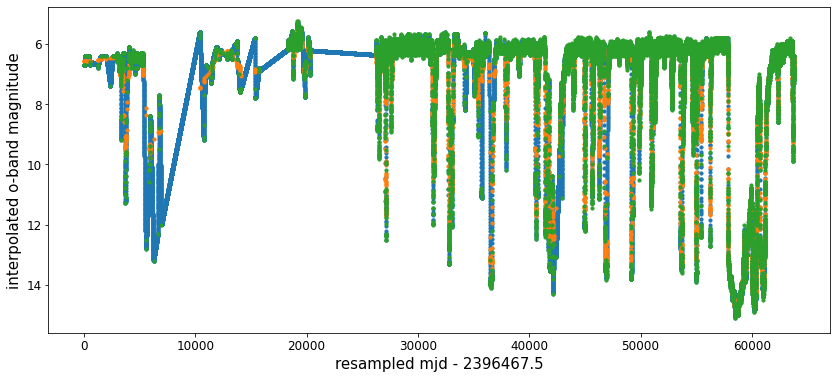

In [290]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(savgol_filtered_oband['m']),s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
# plt.ylim(20.5,11)
# plt.ylim(14,11)
# plt.xlim(1000,1200)
plt.show()

In [291]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

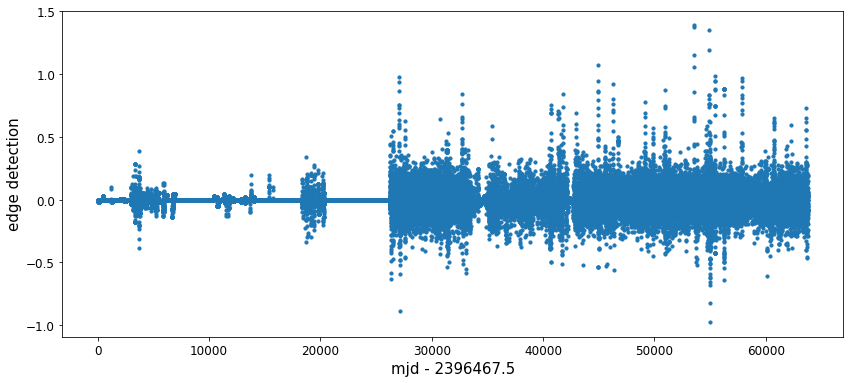

In [292]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

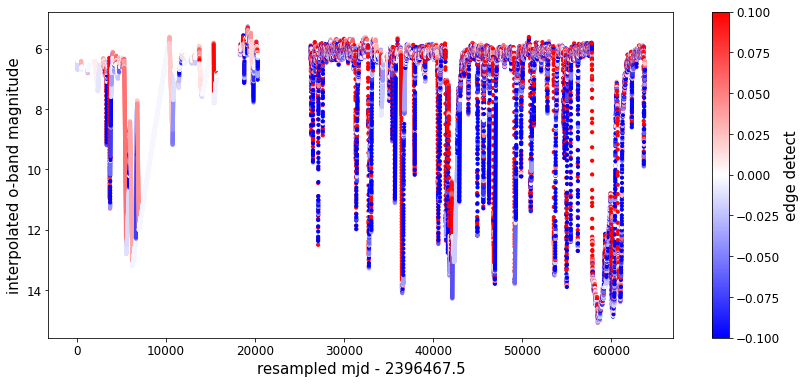

In [293]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [294]:
# kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = Matern(length_scale=3, nu=3/2,length_scale_bounds=(150,1e5)) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [295]:
# # median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

# time = np.asarray(savgol_filtered_oband['mjd']-mjd_scale)
# time = time.reshape(-1,1)

# # the gp assumes the mean value is zero
# mean_val = np.min(savgol_filtered_oband['m'])
# norm_val = np.max(savgol_filtered_oband['m']-mean_val)


# # mean_val = np.min(iter_savgol_filtered)
# # norm_val = np.max(iter_savgol_filtered-mean_val)

In [296]:
# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(time, (savgol_filtered_oband['m']-mean_val)/norm_val)
# # gp.fit(time, (iter_savgol_filtered-mean_val)/norm_val)


# # gp.fit(time, savgol_filtered_oband['m'])
# # GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
# #                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
# #                 n_restarts_optimizer=0, normalize_y=False,
# #                 optimizer='fmin_l_bfgs_b', random_state=None)

In [297]:
# gp.kernel_

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [298]:
# x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
# y_pred, sigma = gp.predict(x_pred, return_std=True)

In [299]:
# plt.figure(figsize=(14,6))

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)
# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,alpha=0.5,color='tab:orange')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,iter_savgol_filtered,s=10,color='tab:blue',alpha=0.75)

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [300]:
# gpsmoothed_time = time
# gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)
# gpsmoothed_flux = (gpsmoothed_flux*norm_val)+mean_val
# gpsigma = gpsigma*norm_val

In [301]:
# plt.figure(figsize=(14,6))

# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [302]:
# gp_edge_detect = sp.ndimage.convolve((y_pred*norm_val)+mean_val, [1.0, 0.0, -1.0])

In [303]:
# # np.std()

# plt.figure(figsize=(14,6))
# plt.scatter(x_pred,gp_edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('edge detection')
# plt.ylim(-0.1,0.1)
# plt.show()

In [304]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(x_pred,(y_pred*norm_val)+mean_val,s=10,
#             c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [305]:
# ### remove this if you don't want to use the gp-filtered data
# resample_time = x_pred
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

In [306]:
# ## interpolate the edge detection to convert back to the original times
# # np.linspace(0, int(np.max(time)), int(np.max(time)))
# gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
#                                                  gp_edge_detect,
#                                                  kind='slinear')

# gp_edges = gp_edgedetect_interp(savgol_filtered_oband['mjd']-mjd_scale)

In [307]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
#             c=gp_edges,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [308]:
# plt.figure(figsize=(14,6))

# plt.scatter(gpsmoothed_time,(savgol_filtered_oband['m']-gpsmoothed_flux)+np.min(savgol_filtered_oband['m']),
#             s=10)#,c=gp_edges,cmap='bwr')
# plt.scatter(gpsmoothed_time,savgol_filtered_oband['m'],s=10,
#             c=savgol_filtered_oband['m']-gpsmoothed_flux,cmap='cividis')#,alpha=0.2)

# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='diff to gp model')
# plt.clim(-0.25,0.25)
# plt.show()

# Now back to normal

In [309]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [310]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [311]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [312]:
# ### toggle this cell for switching between slinear interpolation and GP interpolation ######

# resample_time = x_pred
# resample_time = resample_time.reshape(len(resample_time))
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

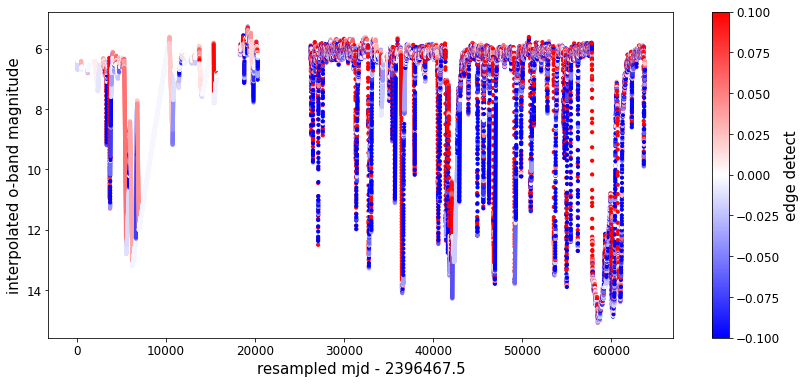

In [313]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

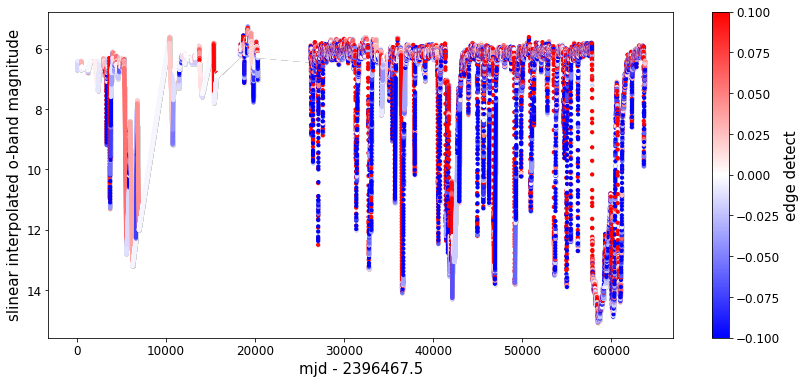

In [314]:
# std_dev = np.std(new_edge_detect)
# # std_dev
# new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
            c=new_edge_detect[new_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][new_mask]-mjd_scale,savgol_filtered_oband['m'][new_mask],s=10,
#             c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

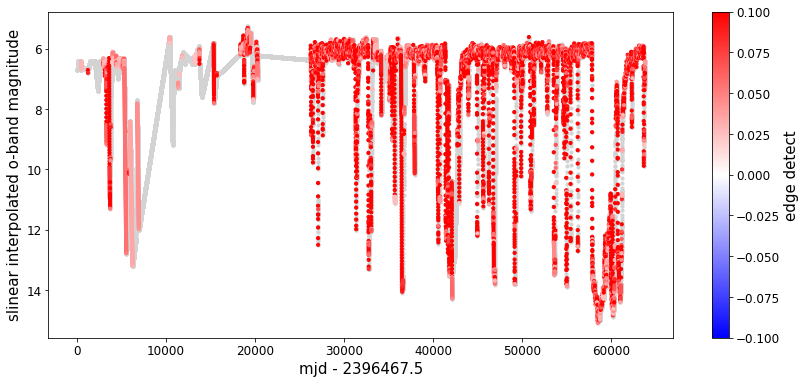

In [315]:
std_dev = np.std(new_edge_detect)
new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
downslope_mask = np.where(new_edge_detect>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=new_edge_detect[total_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [316]:
## this doesn't work with gp filtered data
gradient = np.gradient(resample_flux, resample_time)

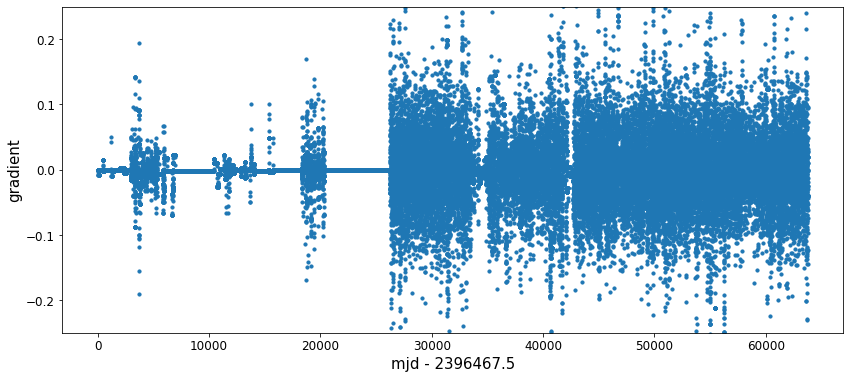

In [317]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('gradient')
plt.ylim(-0.25,0.25)
plt.show()

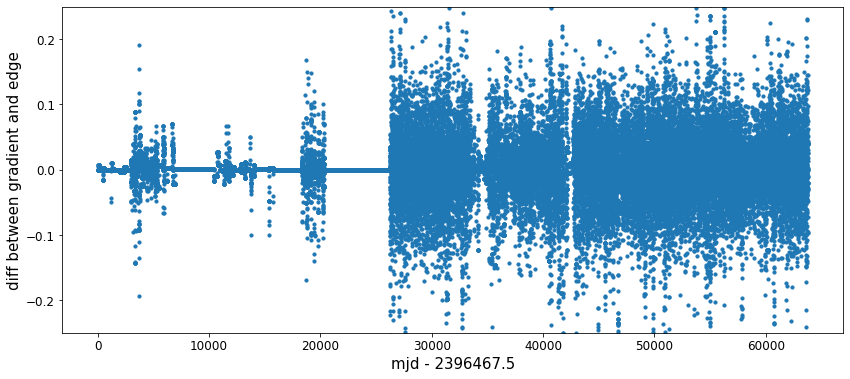

In [318]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient-new_edge_detect,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('diff between gradient and edge')
plt.ylim(-0.25,0.25)
plt.show()

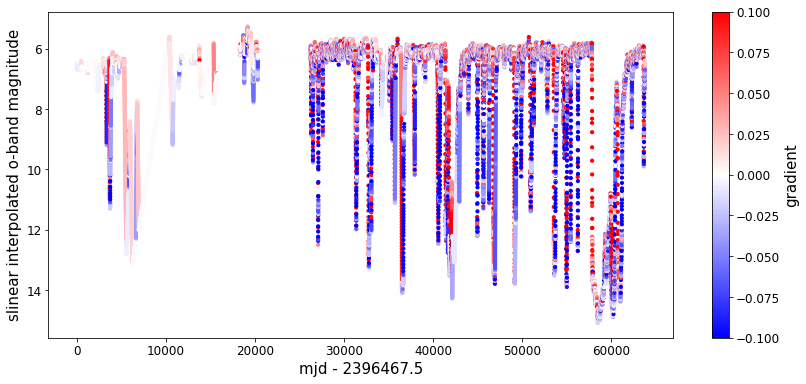

In [319]:
plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
# plt.scatter(resample_time,gradient,s=10,color='lightgrey')
plt.scatter(resample_time,resample_flux,s=10,
            c=gradient,cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

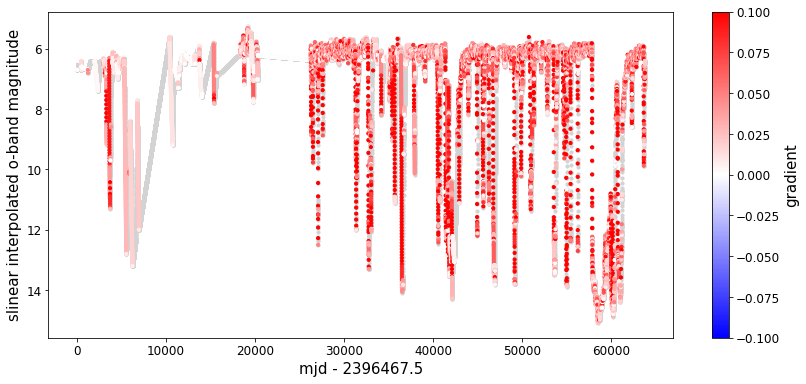

In [320]:
downslope_mask = np.where(gradient>0,True,False)
total_mask = downslope_mask

plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
            c=gradient[downslope_mask],cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [321]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [322]:
run_vals, run_start, run_length = find_runs(total_mask)

In [323]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [324]:
# resample_time[downward_mask]

In [325]:
# resample_time[run_start]

In [326]:
# resample_flux[run_start]

In [327]:
decline_min_depth = 0.9
decline_onset = []
decline_end = []
decline_depth = []
for i in range(0,len(resample_flux[run_start])):
    if i == 0 and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(resample_flux[0])
        print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
        decline_end.append(run_start[i+1])
        decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
    elif i == len(resample_flux[run_start])-1:
        if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(resample_flux[run_start[i]])
            print(resample_flux[-1] - resample_flux[run_start[i]])
            decline_end.append(len(resample_flux)-1)
            decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
    elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(resample_flux[run_start[i]])
        print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
        decline_end.append(run_start[i+1])
        decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
#     if i == len(resample_flux[run_start]):
#         print('end')
print(resample_flux[decline_end])
print(decline_depth)

2003
6.4
0.999683309769968
3281
6.6
2.5919747930698858
3630
6.3
4.695957553705358
5324
6.6
6.193090121640521
5968
8.4
4.797277391267391
6765
7.701848779690599
4.295936627400068
10403
5.601331535980439
3.5913239031644526
13771
6.5
1.0
15356
5.8
1.9956013897740617
19581
5.750390236531408
1.4292665359260504
26283
6.733059777781904
2.105179787638427
26485
7.284227894342147
2.507981068447661
27064
7.001342871630456
5.370372938297239
27586
6.253942792307928
2.5205064710332508
31277
6.68
2.9734131150320504
31341
8.82537466573621
3.1683916558380805
31420
9.071527156213255
1.2424028069249626
32696
5.961989916643784
2.5550489724562926
32723
7.750249507665012
4.31022272510236
32751
12.071679643496422
1.2283203565035787
33042
10.519831053374237
1.5569587577458943
34144
6.075605977644466
1.9429958040002173
34930
6.177173316579286
1.54942684768044
35384
6.428103275787466
2.6418967242125344
35652
6.08
4.809205095444984
36392
6.163082483409982
7.813799451802244
37826
6.16
1.9342224999101436
37873
8.17

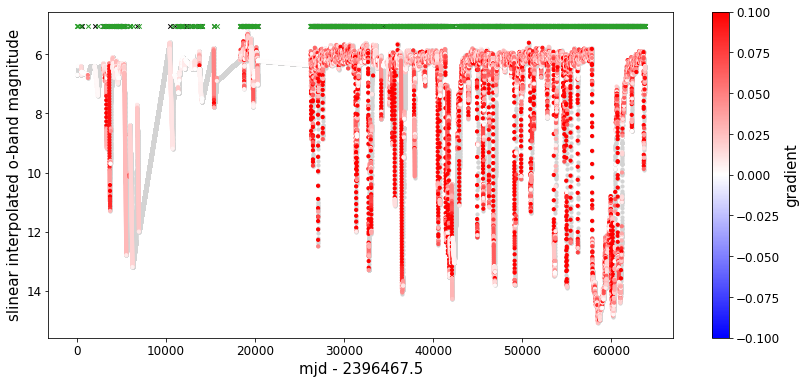

In [328]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downward_mask],
            np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
            s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[upward_mask],
            np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
plt.show()

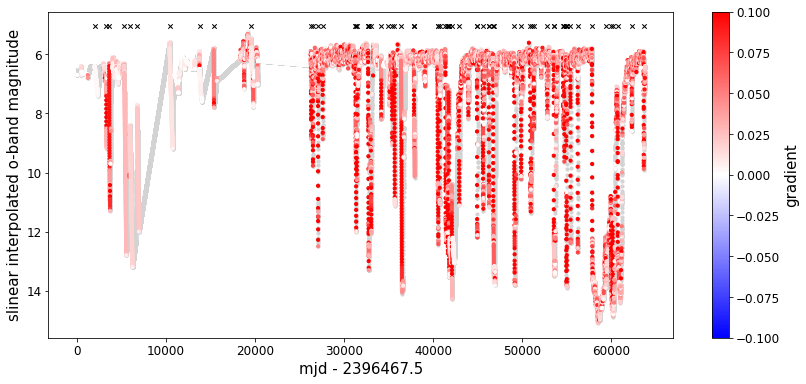

In [329]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
# plt.scatter(resample_time[downward_mask]-mjd_scale,
#             np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[upward_mask]-mjd_scale,
#             np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(resample_time[decline_onset],
            np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

[2003.0547391828568, 3281.089665131779, 3630.099202812666, 5324.145497458577, 5968.163097076031, 6765.18487796906, 10403.284299410514, 13771.376342130365, 15356.419657959035, 19581.535121287827, 26283.71827755518, 26485.72379793208, 27064.73962119063, 27586.753886719067, 31277.854756576242, 31341.85650560655, 31420.858664565832, 32696.893535857558, 32723.89427372972, 32751.895038930477, 33042.90299155265, 34144.93310766823, 34930.954587946675, 35384.96699513041, 35652.974319194815, 36392.99454235772, 37827.033731568015, 37874.03501601215, 37904.035835870105, 40493.1065896117, 40566.108584599395, 40721.112820532166, 41375.1306934356, 41572.13607716952, 41624.13749825664, 41736.14055905968, 41752.14099631725, 42070.14968681159, 42911.172670162945, 44895.226890102436, 44921.227600645994, 45566.245227592044, 46228.26331912427, 46256.264084325034, 46720.276764794755, 46796.27884176824, 49096.34169754486, 49865.36271323713, 50893.39080703642, 51076.39580816995, 51290.40165649004, 52755.44169

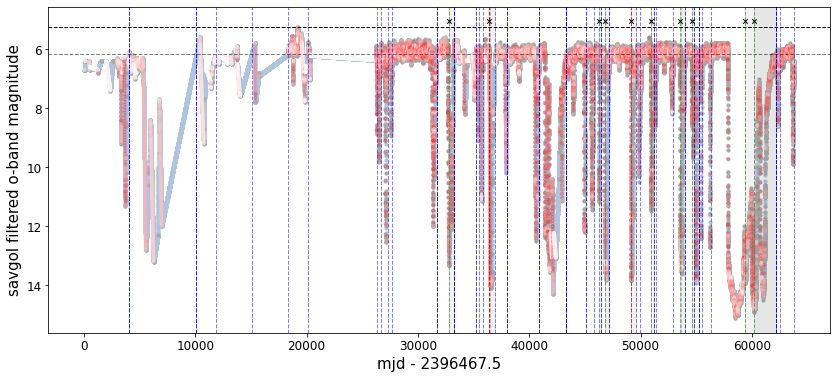

In [342]:
plt.figure(figsize=(14,6))

plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
plt.clim(-0.1,0.1)


onset_arr = []
onset_flag = []
max_depth_arr = []
end_arr = []
end_flag = []

max_light = np.min(resample_flux)
plt.axhline(max_light,color='k',linestyle='--')
plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
for i in range(0,len(resample_time[decline_onset])):
    flag_set = False
    if decline_onset[i] == 0:
#         print('beginning of array')
        onset_flag.append(1)
        flag_set = True
    onset_time = resample_time[decline_onset][i]
    diff_arr = np.abs((savgol_filtered_oband['mjd'][saturation_mask]-mjd_scale)-onset_time)
    if np.min(diff_arr) > 5:
        if decline_depth[i] > 12-np.min(savgol_filtered_oband['m']):
            plt.axvline(onset_time,color='red',linestyle='--')
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
#             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
            if flag_set == False:
                onset_flag.append(2)
#             print('onset', onset_time)
        else:
#             print('bad onset')
            onset_flag.append(3)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
            pass
#             plt.axvline(onset_time,color='red',linestyle='--')
    else:
        plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
        plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
#         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
        if flag_set == False:
            onset_flag.append(0)
        onset_arr.append(onset_time)
        max_depth_arr.append(resample_time[decline_end[i]])
#         print('onset', onset_time)
        
    post_decline_time = resample_time[resample_time>onset_time]
    post_decline_flux = resample_flux[resample_time>onset_time]
    xx = 0
    while post_decline_flux[xx] < (max_light+decline_min_depth):
        xx=xx+1
    else:
#         print('exited max light')
        exit_time = post_decline_time[xx]
        post_decline_time = resample_time[resample_time>exit_time]
        post_decline_flux = resample_flux[resample_time>exit_time]
    
    xx = 0
    try:
        while post_decline_flux[xx] > (max_light+decline_min_depth):
            xx=xx+1
        else:
#             print('reached max light')
#             print(xx,post_decline_flux[xx],post_decline_time[xx])
            plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx])
            end_flag.append(0)
    except IndexError:
#         print('reached end of array')
#         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
        plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
        end_arr.append(post_decline_time[xx-1])
        end_flag.append(1)

        
print(onset_arr)
print(onset_flag)
print(end_arr)
print(end_flag)
print(max_depth_arr)

plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
            np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

for i in range(0,len(onset_arr)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

In [343]:
def return_arr_to_orig(time_array):
    return_arr = []
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-datapt))
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

In [344]:
## resample the times back to the original data set
orig_time = savgol_filtered_oband['mjd']-mjd_scale
onset_arr_orig = return_arr_to_orig(onset_arr)
end_arr_orig = return_arr_to_orig(end_arr)
depth_time_orig = return_arr_to_orig(max_depth_arr)

In [345]:
def err_calculation(time_arr):
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
#     print(len(orig_time))
    err_arr = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
#         print(matched_time_ind)
        if matched_time_ind != 0 and matched_time_ind > 5 and matched_time_ind < (len(orig_time)-6):
            print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
            err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        elif matched_time_ind > (len(orig_time)-6):
            print('end of arr')
            err_arr.append(0)
        else:
            print('beginning of arr')
            err_arr.append(0)
    err_arr = np.asarray(err_arr)
    return err_arr

In [346]:
onset_err_arr = err_calculation(onset_arr_orig)
end_err_arr = err_calculation(end_arr_orig)
depth_err_arr = err_calculation(depth_time_orig)

723.5
26.5
93.5
284.0
396.0
1842.0
2008.5
140.0
2133.75
119.0
6.539999999804422
3.794999999925494
1.9899999999906868
6.165000000037253
6.740000000223517
7.59499999997206
5.385000000009313
2.505000000121072
3.494999999878928
10.744999999878928
6.989999999990687
27.395000000018626
90.55000000004657
18.415000000037253
19.240000000223517
59.205000000074506
15.46999999997206
31.709999999962747
30.179999999934807
21.43999999994412
13.014999999897555
3.4699999999720603
1.9850000001024455
34.39999999990687
11.375
13.020000000018626
6.535000000149012
14.0
5.025000000139698
10.429999999934807
3.9450000000651926
4.185000000055879
2.015000000130385
11.245000000111759
13.878000000026077
17.524999999906868
5.4984999999869615
2.0087000001221895
1.4339999998919666
13.976000000024214
0.509349999949336
1.484700000146404
1.4552499998826534
37.22674999991432
0.50414999993518
4.556099999928847
2.4954499998129904
2.0076500000432134
2.3866500000003725
4.2493000000249594
7.387499999953434
3.227500000037253
9.

In [347]:
## time error calculations based on how many data points are around
err_arr = []
for onset in onset_arr_orig:
    matched_time_ind = np.argmin(np.abs(orig_time-onset))
    if matched_time_ind != 0 and matched_time_ind > 5:
        print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
    else:
        print('beginning of arr')
        err_arr.append(0)
err_arr = np.asarray(err_arr)
#     print(orig_time[matched_time_ind-5:matched_time_ind+5])

723.5
26.5
93.5
284.0
396.0
1842.0
2008.5
140.0
2133.75
119.0
6.539999999804422
3.794999999925494
1.9899999999906868
6.165000000037253
6.740000000223517
7.59499999997206
5.385000000009313
2.505000000121072
3.494999999878928
10.744999999878928
6.989999999990687
27.395000000018626
90.55000000004657
18.415000000037253
19.240000000223517
59.205000000074506
15.46999999997206
31.709999999962747
30.179999999934807
21.43999999994412
13.014999999897555
3.4699999999720603
1.9850000001024455
34.39999999990687
11.375
13.020000000018626
6.535000000149012
14.0
5.025000000139698
10.429999999934807
3.9450000000651926
4.185000000055879
2.015000000130385
11.245000000111759
13.878000000026077
17.524999999906868
5.4984999999869615
2.0087000001221895
1.4339999998919666
13.976000000024214
0.509349999949336
1.484700000146404
1.4552499998826534
37.22674999991432
0.50414999993518
4.556099999928847
2.4954499998129904
2.0076500000432134
2.3866500000003725
4.2493000000249594
7.387499999953434
3.227500000037253
9.

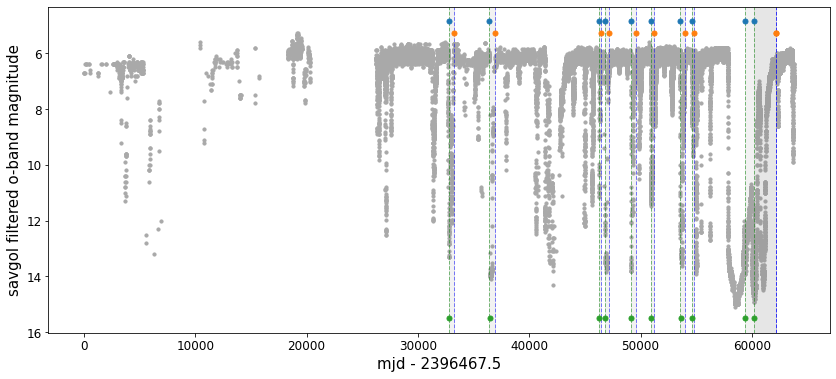

In [348]:
plt.figure(figsize=(14,6))

# plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#             c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
# plt.clim(-0.1,0.1)

# plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
             xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')


# plt.scatter(end_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
             xerr=end_err_arr[np.asarray(onset_flag) != 3],fmt='o')

# plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=depth_time_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
             xerr=depth_err_arr[np.asarray(onset_flag) != 3],fmt='o')


for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
#             np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

# for i in range(0,len(onset_arr)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
plt.show()

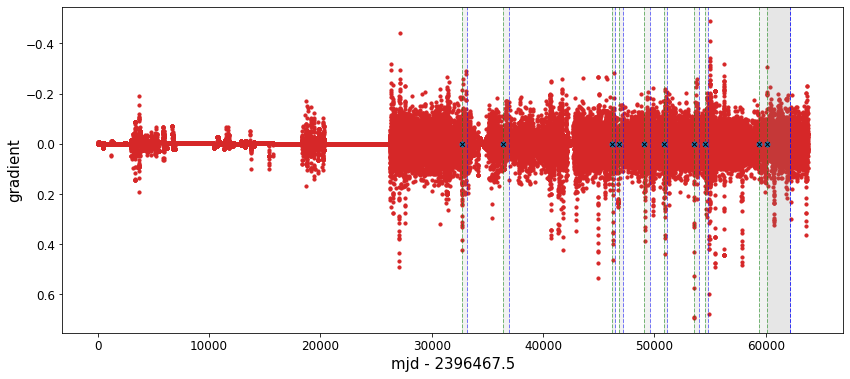

In [349]:
plt.figure(figsize=(14,6))

# plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(resample_time,gradient,s=10,color='tab:red')


# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
#             s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#             c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
# plt.clim(-0.1,0.1)

plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
            np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                    s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
             xerr=err_arr[np.asarray(onset_flag) != 3],fmt='o')

for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
#             np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

# for i in range(0,len(onset_arr)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('gradient')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

In [350]:
## these times are in the resampled array, which has no gaps, compared to the real data
## We'll need to transform back to the original array and use the the distance to a datapoint as an error

decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
                        end_arr_orig,end_err_arr,end_flag,
                        depth_time_orig,depth_err_arr,
                        decline_depth,resample_flux[decline_end]])
decline_frame = pd.DataFrame(decline_arr.T,
                             columns=['onset_time','onset_err','onset_flag','end_time','end_err',
                                      'end_flag','depth_time','depth_err','decline_depth','min_mag'])
decline_frame

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
0,2004.000,723.5000,3.0,4014.0000,105.500,0.0,2364.000,716.0000,0.999683,7.399683
1,3282.000,26.5000,3.0,4014.0000,105.500,0.0,3337.000,35.0000,2.591975,9.191975
2,3631.000,93.5000,3.0,4014.0000,105.500,0.0,3698.000,60.5000,4.695958,10.995958
3,5325.000,284.0000,3.0,10404.0000,2008.500,0.0,5548.000,287.0000,6.193090,12.793090
4,5969.000,396.0000,3.0,10404.0000,2008.500,0.0,6246.000,395.5000,4.797277,13.197277
...,...,...,...,...,...,...,...,...,...,...
63,59958.956,5.5150,3.0,62149.9170,1.034,0.0,59981.944,3.4685,2.100000,13.400000
64,60149.743,24.2290,0.0,62149.9170,1.034,0.0,60174.260,23.2640,2.845807,14.680425
65,60712.035,2.5300,3.0,62149.9170,1.034,0.0,60729.951,5.4775,3.936352,12.700000
66,62280.800,3.4985,3.0,62490.8780,2.001,0.0,62298.819,3.4965,1.693269,8.288395


In [339]:
## can check to see how much data is around the decline point and if none then reject that decline